# Beta-binomial model

In this notebook, we will motivate and analytically analyze the beta-binomial model and then compare the result to a numerical simulation.

In [1]:
from scipy.stats import beta
import numpy as np
import seaborn as sns; sns.set_context('notebook');
import matplotlib.pyplot as plt

%matplotlib inline

## Motivation
We have a treatment and we want to estimate the proportion of successful outcomes $p \in [0,1]$ after observing the results of administering the treatment to patients.  We formulate a clinical trial with the following assumptions: each treatment is independent and identically distributed (would you challenge these assumptions?) according to the Bernoulli distribution with probability of success $p$. Then the number of $x$ successful treatments in $n$ treatment attempts is Binomially distributed.

We start with a prior distribution indicating equal belief in all possible values of $p \in [0,1]$.

## Mathematical setup

This is common for both scenarios.  Modelling assumption: $p$ is Beta distributed.  Our preferences then require that the prior is $p \sim \mathrm{Beta}(1,1)$, so

$$f(p,\alpha,\beta) = \frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)} p^{\alpha-1} (1-p)^{\beta-1}.$$

Note: $\Gamma(x) = \int_{0}^\infty t^{x-1} \exp(-t) \mathrm{dt}$ is called the [gamma function](https://en.wikipedia.org/wiki/Gamma_function) (we don't need the integral anywhere, I just think it's cool) and for natural numbers $n$ we have $\Gamma(n) = (n-1)!$.

The likelihood is binomial, so given a probability of success $p$, we have

$$f(x|p,n) = \binom{n}{x} p^x(1-p)^{n-x}.$$

We want to solve for the posterior $f(p|x,n)$, which is proportional to

$$f(p|x,n) \propto f(p,\alpha,\beta)f(x|p,n).$$

We also know (via analytical derivation done on the board) that the analytical solution of the posterior is:

$$f(p|x,n) = \mathrm{Beta}(\alpha+x,\beta+n-x).$$

In [2]:
def prior_pdf(p):
    return beta.pdf(p,1,1)

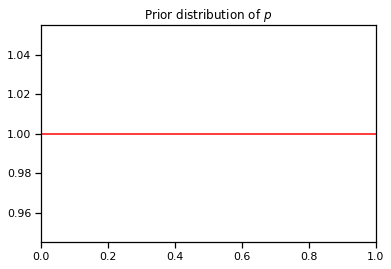

In [3]:
# I'm using z in place of p so I don't conflict later
# what you see is the density of p
z = np.linspace(0,1,100)
plt.plot(z, prior_pdf(z), color="r")
plt.xlim([0,1])
plt.title('Prior distribution of $p$')
plt.show()

In [4]:
def posterior_pdf(p,x,n):
    # given our prior was Beta(1,1), our posterior will be
    # Beta(1+x,1+n-x)
    return beta.pdf(p, x+1, n-x+1)

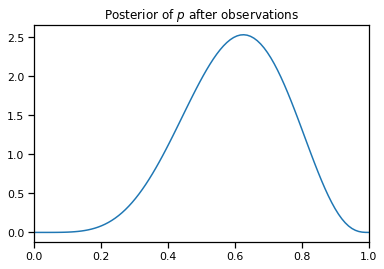

In [5]:
# experimental data
data = [1,1,0,1,0,1,1,0]
n, x = len(data), sum(data)

p = np.linspace(0,1,100)
plt.plot(p, posterior_pdf(p, x, n))
plt.xlim([0,1])
plt.title('Posterior of $p$ after observations')
plt.show()

### Coin flip experiment
Supposing we want to know whether a credible interval contains $p=0.5$.  A [credible interval](https://en.wikipedia.org/wiki/Credible_interval) is the "Bayesian equivalent" of a confidence interval.

I will build the 95% credible interval by considering the interval between the 0.025 and 0.975 quantiles.

In [6]:
[beta.ppf(0.025,x+1,n-x+1), beta.ppf(0.975,x+1,n-x+1)]

[0.2992950562085404, 0.8630043377348335]

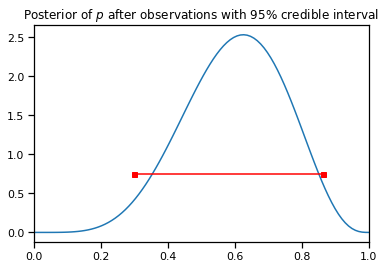

In [7]:
p = np.linspace(0,1,100)
plt.plot(p, posterior_pdf(p, x, n))
plt.plot([beta.ppf(0.025, x+1, n-x+1), beta.ppf(0.975, x+1, n-x+1)],
         [0.75, 0.75], color='r', marker='s', markersize=5)
plt.xlim([0,1])
plt.title('Posterior of $p$ after observations with 95% credible interval')
plt.show()

### "Monitoring" the progress
Since the Beta and Binomial distributions are conjugate, we can proceed iteratively along experiments of size $n=1$ and plot the posterior (which we know is Beta distributed) after each data point. The postrior then becomes a new prior for the next observation. So we can examine the distribution after each single trial.

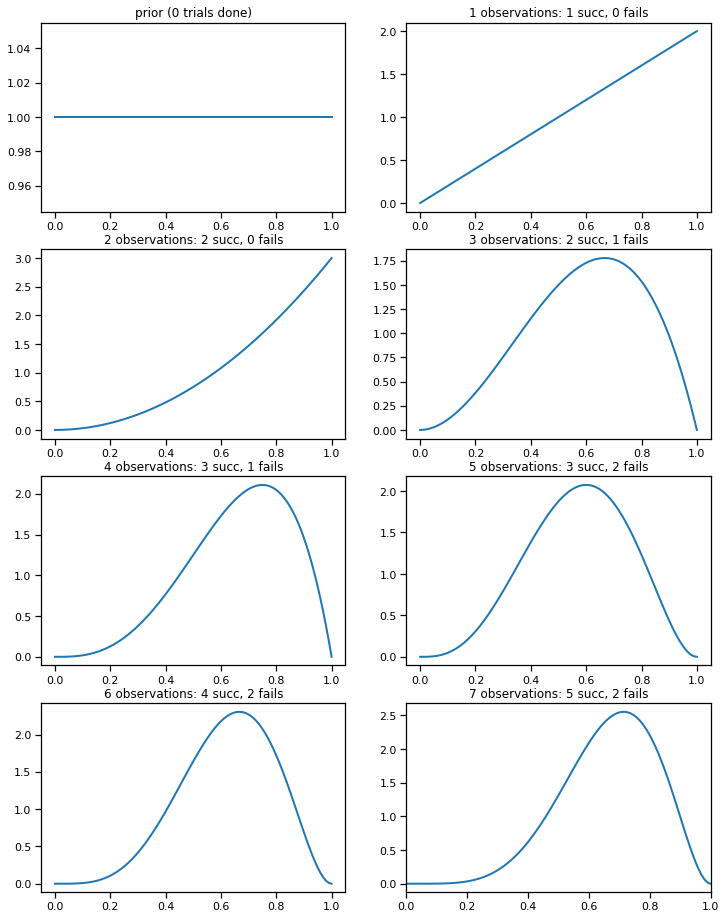

In [8]:
plt.figure(figsize=(12, 16))
p = np.linspace(0, 1, 100)
legend = []
for n in range(0, len(data)):
    # update experiment after i-th trial
    succs = np.sum(data[:n]) 
    plt.subplot(4, 2, n+1)
    plt.plot(p, posterior_pdf(p, succs, n), linewidth=2)
    plt.title('%d observations: %d succ, %d fails' % (n,succs,n-succs) if n > 0 else 'prior (0 trials done)')
plt.xlim([0,1])
plt.show()

## Solution using PyMC3
Let's build the same model and examine numerical solutions from PyMC3.

In [9]:
import pymc3 as pm

In [10]:
with pm.Model() as bb_model:
    p = pm.Beta('p', alpha=1, beta = 1)
    trials = pm.Binomial('trials', p=p, n=len(data), observed=sum(data))

### MAP estimate
The maximum aposteriori probability (MAP) estimate should plant itself right into the point with the highest probability density, that is (for a general $\theta$):

$$\theta_{\mathrm{MAP}} = \mathrm{argmax}_\theta\frac{f(D|\theta)f(\theta)}{f(D)}.$$

In [12]:
map_estimate = pm.find_MAP(model=bb_model)

logp = -1.5198, ||grad|| = 1: 100%|█████████████████████████████████████████████████████| 7/7 [00:00<00:00, 859.41it/s]


In [13]:
map_estimate

{'p_logodds__': array(0.51082563), 'p': array(0.625)}

Let us compare the posterior after all observations to the MAP estimate of $p$ to check if it corresponds to its mode.

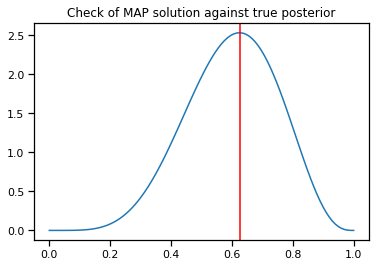

In [14]:
### Compare the MAP estimate to the known analytical posterior
plt.plot(z, posterior_pdf(z, sum(data), len(data)))
plt.axvline(map_estimate['p'], color='red')
plt.title('Check of MAP solution against true posterior')
plt.show()

### MCMC solution
We will now sample the posterior, plot the histogram and compare to the true posterior as before.

In [15]:
with bb_model:
    # draw posterior samples
    trace = pm.sample(draws=5000, tune=1000, cores=1) #chains=1

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p]
Sampling chain 1, 0 divergences: 100%|███████████████████████████████████████████| 6000/6000 [00:03<00:00, 1960.01it/s]


D:\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
D:\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


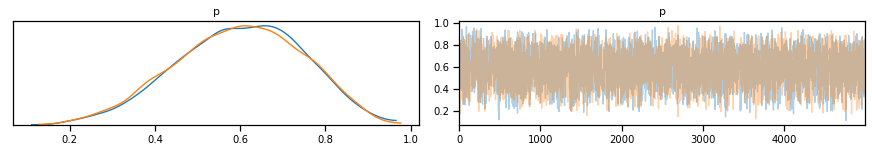

In [16]:
_ = pm.traceplot(trace)

Let us look at the result of the simulation using only the first 500 samples.  We se that while we capture the general features of the density, our estimate is not really very close.

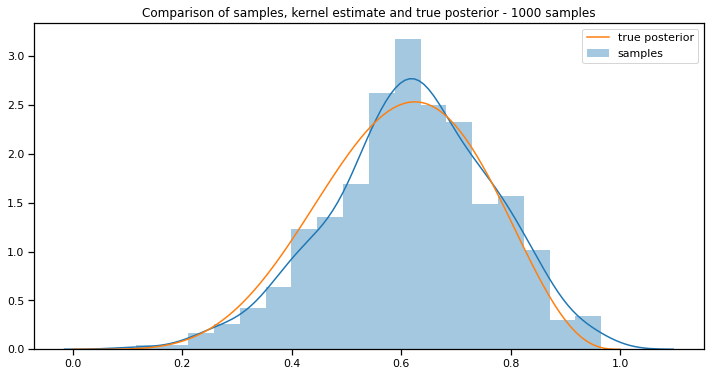

In [17]:
plt.figure(figsize=(12,6))
sns.distplot(trace['p'][:500])
plt.plot(z, posterior_pdf(z, sum(data), len(data)))
plt.legend(['true posterior', 'samples'])
plt.title('Comparison of samples, kernel estimate and true posterior - 1000 samples')
plt.show()

Using all of the samples improves the correspondence of the estimated and true posterior considerably.  It is in general difficult to conclude when we have obtained enough samples and this problem is relegated to later sections.

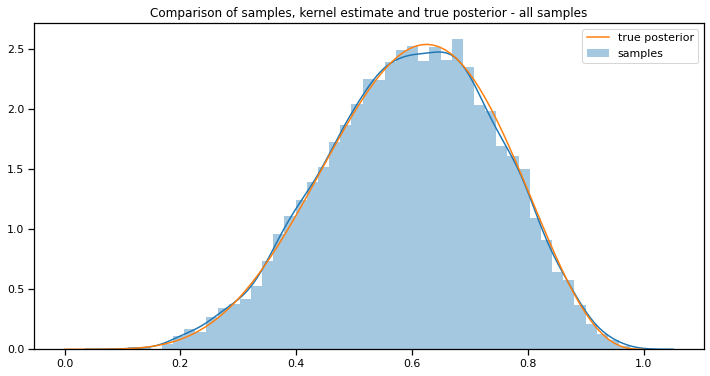

In [18]:
plt.figure(figsize=(12,6))
sns.distplot(trace['p'])
plt.plot(z, posterior_pdf(z, sum(data), len(data)))
plt.legend(['true posterior', 'samples'])
plt.title('Comparison of samples, kernel estimate and true posterior - all samples')
plt.show()

In [19]:
# the expected value from the samples (does NOT in general correspond to the mode, which is computed by the MAP)
np.mean(trace['p']), np.median(trace['p'])

(0.5977782856006795, 0.6035958230269431)

In [20]:
# However, the maximum likelihood estimate should be equal to the MAP under the uniform prior.
float(sum(data))/len(data)

0.625

In [21]:
# Let us look at the summary statistics of the posterior. 
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p,0.598,0.148,0.332,0.874,0.002,0.002,4214.0,4070.0,4237.0,6549.0,1.0


## Conclusions
We have analytically computed the posterior distribution in our model and compared it to the MAP solution and to a solution obtained by MCMC sampling.

Observations:
- The credible interval after only 7 observations is very wide $p \in [0.35,0.91]$.
- The MAP solution corresponds to the mode of the posterior distribution.
- The numerical simulation corresponds closely to the computed analytical solution if enough samples are obtained.